# Kaggle March Madness Challenge 2018

Google Cloud and NCAA® have teamed up to bring you this year’s version of the Kaggle machine learning competition. Another year, another chance to anticipate the upsets, call the probabilities, and put your bracketology skills to the leaderboard test. Kagglers will join the millions of fans who attempt to forecast the outcomes of March Madness® during this year's NCAA Division I Men’s and Women’s Basketball Championships. But unlike most fans, you will pick your bracket using a combination of NCAA’s historical data and your computing power, while the ground truth unfolds on national television.

- Challenge Home: https://www.kaggle.com/c/mens-machine-learning-competition-2018



- Basic Logistic Regression Starter Kernel: https://www.kaggle.com/osciiart/basic-starter-kernel-ncaa-men-s-dataset-with-jp


- Least Squares Starter Kernel: https://www.kaggle.com/baeng72/basic-least-squares-ratings


- NCAA Tournaments Competition Walkthrough: https://www.kaggle.com/asindico/ncaa-tournaments-competition-walkthrough


- Basic Starter Kernel: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-men-s-dataset


- Feature Engineering with Advanced Statistics: https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stats


- FiveThirtyEight Elo Ratings: https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings


- Extensive NCAA Exploratory Analysis: https://www.kaggle.com/captcalculator/a-very-extensive-ncaa-exploratory-analysis



### Preparation
Import packages and load in initial datasets

In [23]:
from tqdm import tqdm

In [24]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [133]:
data_dir = './2022/MDataFiles_Stage1/'
sub_dir = './2022/'
stage2_dir = './2022/MDataFiles_Stage2/'


In [26]:
df_seeds = pd.read_csv(data_dir + 'MNCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')

In [27]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [28]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


### Seed Based Logistic Regression
Using just seeding the predict winner and confidence, use this as baseline model

In [29]:
# Convert seed to int
df_seeds['Seed_int'] = df_seeds['Seed'].str[1:3]
df_seeds['Seed_int'] = df_seeds['Seed_int'].apply(pd.to_numeric)
df_seeds.head()

,Season,Seed,TeamID,Seed_int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [30]:
# Drop unnecessary columns
df_seeds.drop(labels=['Seed'], inplace=True, axis=1)
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

In [31]:
df_seeds.head()

,Season,TeamID,Seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [32]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [33]:
# Merge dataframes
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [34]:
# Create training data set
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [35]:
X_train = df_predictions['SeedDiff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [36]:
# Create and test model
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5569, with best C: 0.021544346900318846


In [37]:
# Store model results
df_results = pd.DataFrame({'Type': ['Seed Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss'])
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.556946


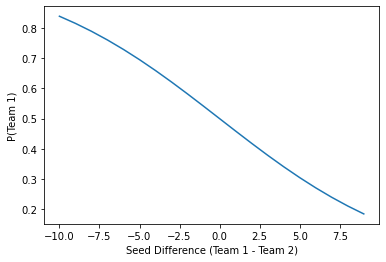

In [38]:
# Vizualization
X = np.arange(-10, 10).reshape(-1, 1);
preds = clf.predict_proba(X)[:,1];

plt.plot(X, preds);
plt.xlabel('Seed Difference (Team 1 - Team 2)');
plt.ylabel('P(Team 1)');

### Average Ranking Based Logistic Regression Model

In [40]:
df_massey = pd.read_csv(data_dir + 'MMasseyOrdinals.csv')

In [41]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [42]:
# Create composite final rankings
final_day = 133
df_final_rankings = df_massey.loc[df_massey['RankingDayNum'] == final_day]
df_final_rankings = df_final_rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean()
df_final_rankings = df_final_rankings.reset_index()
df_final_rankings.rename(columns={'OrdinalRank':'Avg. Rank'}, inplace=True)

In [43]:
df_final_rankings.head()

,Season,TeamID,Avg. Rank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


In [46]:
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [47]:
# Join tournament results
df_win_ranks = df_final_rankings.rename(columns={'TeamID':'WTeamID', 'Avg. Rank':'WAvgRank'})
df_loss_ranks = df_final_rankings.rename(columns={'TeamID':'LTeamID', 'Avg. Rank':'LAvgRank'})
df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
df_concat['ScoreDiff'] = df_concat['WScore'] - df_concat['LScore']
df_concat['RankDiff'] = df_concat['WAvgRank'] - df_concat['LAvgRank']
df_total = df_concat[['Season', 'DayNum', 'WTeamID','LTeamID', 'WAvgRank', 'LAvgRank', 'RankDiff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDiff
0,2003,134,1421,1411,240.343750,239.281250,1.062500
1,2003,136,1112,1436,2.676471,153.125000,-150.448529
2,2003,136,1113,1272,36.000000,21.705882,14.294118
3,2003,136,1141,1166,45.687500,20.735294,24.952206
4,2003,136,1143,1301,36.406250,50.312500,-13.906250


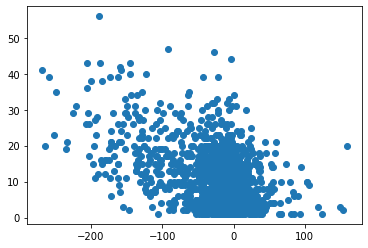

In [48]:
# Is ranking difference correlated with score difference?
plt.scatter(df_concat['RankDiff'], df_concat['ScoreDiff']);

In [49]:
# Create testing and training sets
df_wins = pd.DataFrame()
df_wins['RankDiff'] = df_total['RankDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['RankDiff'] = -df_total['RankDiff']
df_losses['Result'] = 0

In [50]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,RankDiff,Result
0,1.062500,1
1,-150.448529,1
2,14.294118,1
3,24.952206,1
4,-13.906250,1


In [51]:
X_train = df_predictions['RankDiff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [52]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5547, with best C: 0.0016681005372000592


In [53]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['Avg. Ranking Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.556946
0,Avg. Ranking Based Logistic Regression,-0.554708


### FiveThirtyEight Elo Logistic Regression Implementation

In [54]:
# Homecourt Bonus
HOME_ADVANTAGE = 100 
# Learning rate
K = 22

In [55]:
# Load regular season data
rs = pd.read_csv(data_dir + 'MRegularSeasonCompactResults.csv')
rs.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [56]:
# Teams
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

372

In [57]:
# Score lookup dict
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [58]:
# New columns to help us iteratively update elos
rs['margin'] = rs.WScore - rs.LScore
rs['w_elo'] = None
rs['l_elo'] = None

In [59]:
# Elo calculation
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [60]:
# Check order
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [61]:
range(rs.shape[0])

range(0, 174471)

In [62]:
# Iterate through all games
preds = []
for i in tqdm(range(rs.shape[0]), desc="Loading..."):
    
    # Get key data from current row
    w = rs.at[i, 'WTeamID']
    l = rs.at[i, 'LTeamID']
    margin = rs.at[i, 'margin']
    wloc = rs.at[i, 'WLoc']
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    preds.append(pred)
    
    # Stores new elos in the games dataframe
    rs.loc[i, 'w_elo'] = elo_dict[w]
    rs.loc[i, 'l_elo'] = elo_dict[l]

Loading...: 100%|██████████| 174471/174471 [58:18<00:00, 49.87it/s]


In [63]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [64]:
df_list = [final_elo_per_season(rs, i) for i in team_ids]
season_elos = pd.concat(df_list)

In [65]:
season_elos.head()

,team_id,season,season_elo
134286,1101,2014,1317.046906
139681,1101,2015,1201.111852
145038,1101,2016,1213.735772
150369,1101,2017,1233.861895
155760,1101,2018,1295.57557


In [68]:
# Logistic Regression
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season':'Season', 'season_elo':'W_Elo'}) #
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season':'Season', 'season_elo':'L_Elo'}) #
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,1116,1234,1591.577794,1611.13548,-19.557686
1,1985,1120,1345,1571.383932,1582.630293,-11.246362
2,1985,1207,1250,1748.491322,1430.346043,318.14528
3,1985,1229,1425,1582.036358,1578.096133,3.940226
4,1985,1242,1325,1615.962789,1600.978706,14.984084


In [69]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

In [70]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Elo_Diff,Result
0,-19.557686,1
1,-11.246362,1
2,318.14528,1
3,3.940226,1
4,14.984084,1


In [71]:
X_train = df_predictions['Elo_Diff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [72]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5464, with best C: 1e-05


In [73]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['FiveThirtyEight Elo Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.556946
0,Avg. Ranking Based Logistic Regression,-0.554708
0,FiveThirtyEight Elo Logistic Regression,-0.546440


### Select Ranking Systems

In [76]:
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [77]:
# Get list of all ranking systems
ranking_types = df_massey['SystemName'].unique().tolist()
ranking_types = [e for e in ranking_types if e not in ('MIC', 'GC', 'RAG', 'TOL', 'EBB', 'BP5', 'MPI', 'BOW', 'CTL')]
print(ranking_types)

['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV', 'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK', 'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL', 'HOL', 'COL', 'DOL', 'GRS', 'HER', 'TSR', 'WTE', 'BD', 'MGY', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM', 'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH', 'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB', 'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM', 'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'LMC', 'RT', 'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'PTS', 'KOS', 'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT', 'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM', 'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'STS', 'UPS', 'SPR', 'MvG', 'TRK', 'BWE', 'HAS', 'FSH', 'DAV', 'KPI', 'FAS', 'MCL', 'HRN', 'RSL', 'SMN', 'DDB', 'INP', 'JRT', 'ESR', 'FMG', 'PRR', 'SMS', 'HKS', 'MUZ', 'OCT', '

In [78]:
# Iterate through each ranking and check log loss
def logreg_type(mytype):
    df_type = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == mytype)]
    df_type = df_type.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_type.rename(columns={'OrdinalRank':'Type Rank'}, inplace=True)

    df_win_ranks = df_type.rename(columns={'TeamID':'WTeamID', 'Type Rank':'WTypeRank'})
    df_loss_ranks = df_type.rename(columns={'TeamID':'LTeamID', 'Type Rank':'LTypeRank'})
    df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
    df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
    df_concat['RankDiff'] = df_concat['WTypeRank'] - df_concat['LTypeRank']
    df_total = df_concat[['Season', 'WTeamID','LTeamID', 'WTypeRank', 'LTypeRank', 'RankDiff']]
    
    if len(df_total) > 980:
        df_wins = pd.DataFrame()
        df_wins['RankDiff'] = df_total['RankDiff']
        df_wins['Result'] = 1
        df_losses = pd.DataFrame()
        df_losses['RankDiff'] = -df_total['RankDiff']
        df_losses['Result'] = 0

        df_predictions = pd.concat((df_wins, df_losses))

        X_train = df_predictions['RankDiff'].values.reshape(-1,1)
        Y_train = df_predictions['Result'].values
        X_train, Y_train = shuffle(X_train, Y_train)
        if np.isnan(np.sum(X_train)) == False:

            logregtype = LogisticRegression()
            params = {'C': np.logspace(start=-5, stop=5, num=10)}
            clf = GridSearchCV(logregtype, params, scoring='neg_log_loss', refit=True)
            clf.fit(X_train, Y_train)

            print('{} - Best log_loss: {:.4}, with best C: {}'.format(mytype, clf.best_score_, clf.best_params_['C']))
            return(pd.DataFrame({'Type': [mytype], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
        return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))
    return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))

In [79]:
df_type_scores = pd.DataFrame(columns=['Type', 'Log Loss'])
for mytype in ranking_types:
    df_type_scores = df_type_scores.append(logreg_type(mytype))

SEL - Best log_loss: -0.5663, with best C: 0.0001291549665014884
BIH - Best log_loss: -0.5663, with best C: 0.0016681005372000592
MOR - Best log_loss: -0.5552, with best C: 0.0016681005372000592
POM - Best log_loss: -0.5566, with best C: 0.0001291549665014884
RPI - Best log_loss: -0.5586, with best C: 0.0016681005372000592
SAG - Best log_loss: -0.5554, with best C: 0.0016681005372000592
WLK - Best log_loss: -0.5549, with best C: 0.0016681005372000592
WOB - Best log_loss: -0.5706, with best C: 0.0001291549665014884
RTH - Best log_loss: -0.5551, with best C: 0.0001291549665014884
WOL - Best log_loss: -0.5563, with best C: 0.0016681005372000592
COL - Best log_loss: -0.5664, with best C: 0.0001291549665014884
DOL - Best log_loss: -0.5619, with best C: 0.0001291549665014884
CNG - Best log_loss: -0.5547, with best C: 0.0016681005372000592
WIL - Best log_loss: -0.5681, with best C: 0.0001291549665014884
DOK - Best log_loss: -0.5653, with best C: 0.0001291549665014884


In [80]:
df_type_scores = df_type_scores.loc[df_type_scores['Log Loss'] != 999]
df_type_scores.sort_values(by='Log Loss', ascending=False, inplace=True)
df_type_scores

,Type,Log Loss
0,CNG,-0.554685
0,WLK,-0.554876
0,RTH,-0.555126
0,MOR,-0.555174
0,SAG,-0.555434
0,WOL,-0.556276
0,POM,-0.556580
0,RPI,-0.558598
0,DOL,-0.561917
0,DOK,-0.565312


### Final Model Selection
Right now, I have a couple different metric options to test, tune, and consider for use in the upcoming tournament:
1. FiveThirtyEight Elo Ratings
2. Average Select Ranking Systems
3. Composite Model

### 1. FiveThirtyEight Elo Ratings Model

In [81]:
# How does Elo perform alone?
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season_elo':'W_Elo', 'season':'Season'})
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season_elo':'L_Elo', 'season':'Season'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,136,1116,1234,1591.577794,1611.13548,-19.557686
1,1985,136,1120,1345,1571.383932,1582.630293,-11.246362
2,1985,136,1207,1250,1748.491322,1430.346043,318.14528
3,1985,136,1229,1425,1582.036358,1578.096133,3.940226
4,1985,136,1242,1325,1615.962789,1600.978706,14.984084


In [82]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result
0,1985,136,1116,1234,-19.557686,1
1,1985,136,1120,1345,-11.246362,1
2,1985,136,1207,1250,318.14528,1
3,1985,136,1229,1425,3.940226,1
4,1985,136,1242,1325,14.984084,1


In [83]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

4542

In [84]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Elo_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Elo_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

-0.5453800732621753

In [85]:
# 2014-2017 results
Y_pred = clf.predict(X_test)
df_test['Elo_Pred'] = Y_pred
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result,Elo_Pred
2312,2021,148,1211,1425,-312.120189,0,0
2313,2021,148,1417,1276,210.844733,0,1
2314,2021,152,1124,1222,-68.332508,0,0
2315,2021,152,1211,1417,-381.643654,0,0
2316,2021,154,1124,1211,111.800762,0,1


In [86]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[315 129]
 [129 315]] 

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       444
           1       0.71      0.71      0.71       444

    accuracy                           0.71       888
   macro avg       0.71      0.71      0.71       888
weighted avg       0.71      0.71      0.71       888



### 2. Average Select Ranking Systems
We will pull and average the top performing rankings from our analysis before:
1. SAG 
2. WLK
3. POM
4. MOR

In [87]:
# Pull various system rankings
df_topranks = season_elos.loc[:, season_elos.columns != 'Elo']
df_topranks = df_topranks.rename(columns={'team_id':'Team_ID', 'season':'Season'}) 

df_temp = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'SAG')]
df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

df_temp2 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'WLK')]
df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp2.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

df_temp3 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'POM')]
df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

df_temp4 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'MOR')]
df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

df_topranks = pd.merge(left=df_topranks, right=df_temp, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp2, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp3, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp4, how='left', on=['Season', 'Team_ID'])

In [88]:
# Mean of all four systems
df_topranks['MeanRank'] = (df_topranks['SAG'] + df_topranks['WLK'] + df_topranks['POM'] + df_topranks['MOR']) / 4
df_topranks.dropna(inplace = True)
df_topranks.head()

,Team_ID,Season,season_elo,SAG,WLK,POM,MOR,MeanRank
0,1101,2014,1317.046906,346.0,330.0,348.0,349.0,343.25
1,1101,2015,1201.111852,336.0,332.0,332.0,346.0,336.50
2,1101,2016,1213.735772,320.0,304.0,318.0,311.0,313.25
3,1101,2017,1233.861895,305.0,307.0,300.0,317.0,307.25
4,1101,2018,1295.57557,276.0,261.0,262.0,265.0,266.00


In [89]:
# Join with tournament dataframe
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_topranks.drop(labels=['SAG', 'WLK', 'POM', 'MOR'], inplace=True, axis=1)

df_win_elos = df_topranks.rename(columns={'Team_ID':'WTeamID', 'MeanRank':'W_MeanRank'})
df_loss_elos = df_topranks.rename(columns={'Team_ID':'LTeamID', 'MeanRank':'L_MeanRank'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['MeanRank_Diff'] = df_concat['W_MeanRank'] - df_concat['L_MeanRank']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,season_elo_x,W_MeanRank,season_elo_y,L_MeanRank,MeanRank_Diff
0,2003,134,1421,1411,1318.061247,259.50,1288.791577,264.50,-5.00
1,2003,136,1112,1436,2051.077363,2.75,1442.803333,160.50,-157.75
2,2003,136,1113,1272,1787.953769,30.00,1833.366259,22.00,8.00
3,2003,136,1141,1166,1663.705965,45.00,1835.575969,24.25,20.75
4,2003,136,1143,1301,1862.127821,39.00,1825.555407,44.00,-5.00


In [90]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['MeanRank_Diff'] = df_concat['MeanRank_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['MeanRank_Diff'] = -df_concat['MeanRank_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result
0,2003,134,1421,1411,-5.00,1
1,2003,136,1112,1436,-157.75,1
2,2003,136,1113,1272,8.00,1
3,2003,136,1141,1166,20.75,1
4,2003,136,1143,1301,-5.00,1


In [91]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

2274

In [92]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['MeanRank_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['MeanRank_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf2 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf2.fit(X_train, Y_train)
clf2.score(X_train, Y_train)

-0.5450159997861028

In [93]:
len(Y_test)

888

In [94]:
len(Y_pred)

888

In [95]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[315 129]
 [129 315]] 

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       444
           1       0.71      0.71      0.71       444

    accuracy                           0.71       888
   macro avg       0.71      0.71      0.71       888
weighted avg       0.71      0.71      0.71       888



### 3. Composite Model
Standardize the elo ratings and rankings and take the mean for logistic regression.

In [96]:
# Set up and drop null rows
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
df.head()

,Team_ID,Season,Elo,season_elo,MeanRank
0,1101,2014,1317.046906,1317.046906,343.25
1,1101,2015,1201.111852,1201.111852,336.50
2,1101,2016,1213.735772,1213.735772,313.25
3,1101,2017,1233.861895,1233.861895,307.25
4,1101,2018,1295.57557,1295.57557,266.00


In [97]:
# Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

In [98]:
# Model 1
df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
df.head()

# Model 2
#df['Composite Score'] = (df['Elo_Scaled'] + (df['MeanRank_Scaled'])) / 2
#df.head()

,Team_ID,Season,Elo,season_elo,MeanRank,Elo_Scaled,MeanRank_Scaled,Composite Score
0,1101,2014,1317.046906,1317.046906,343.25,0.369483,0.024929,0.139780
1,1101,2015,1201.111852,1201.111852,336.50,0.283729,0.044160,0.124016
2,1101,2016,1213.735772,1213.735772,313.25,0.293066,0.110399,0.171288
3,1101,2017,1233.861895,1233.861895,307.25,0.307953,0.127493,0.187646
4,1101,2018,1295.57557,1295.57557,266.00,0.353601,0.245014,0.281210


In [99]:
# Join tournament dataframe
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Composite_Diff'] = df_concat['W_Composite'] - df_concat['L_Composite']
df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite', 'Composite_Diff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite,Composite_Diff
0,2003,134,1421,1411,0.299099,0.282386,0.016713
1,2003,136,1112,1436,0.967484,0.517890,0.449594
2,2003,136,1113,1272,0.850852,0.877244,-0.026391
3,2003,136,1141,1166,0.791728,0.873515,-0.081787
4,2003,136,1143,1301,0.852046,0.833532,0.018514


In [100]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Composite_Diff'] = df_concat['Composite_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Composite_Diff'] = -df_concat['Composite_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result
0,2003,134,1421,1411,0.016713,1
1,2003,136,1112,1436,0.449594,1
2,2003,136,1113,1272,-0.026391,1
3,2003,136,1141,1166,-0.081787,1
4,2003,136,1143,1301,0.018514,1


In [101]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

2274

In [102]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Composite_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Composite_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             scoring='neg_log_loss')

In [103]:
# Training score
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.5420244359146412

In [104]:
# Save model
filename = sub_dir + 'ncaa_tourney1.pkl'
#filename = 'ncaa_tourney2.pkl'
pickle.dump(clf3, open(filename, 'wb'))

In [105]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[315 129]
 [129 315]] 

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       444
           1       0.71      0.71      0.71       444

    accuracy                           0.71       888
   macro avg       0.71      0.71      0.71       888
weighted avg       0.71      0.71      0.71       888



### Model Performance

In [106]:
# 2014-2017 log loss
Y_pred = clf3.predict(X_test)
df_test['Pred'] = Y_pred
clf3.score(X_test, Y_test)

-0.5427444501044031

In [107]:
# Probabilities
probs = clf3.predict_proba(X_test)
Y_prob = [max(item[0],item[1]) for item in probs]
df_test['Prob'] = Y_prob

df_test.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Pred,Prob
717,2014,136,1163,1386,0.082964,1,1,0.674966
718,2014,136,1173,1326,-0.126716,1,0,0.753263
719,2014,136,1196,1107,0.485757,1,1,0.986326
720,2014,136,1217,1153,-0.062255,1,0,0.633748
721,2014,136,1257,1264,0.247778,1,1,0.898656


In [109]:
# Teams dataframe
teams = pd.read_csv(data_dir + 'MTeams.csv')
teams.head()

df_dummy = teams.rename(columns={'TeamID':'WTeamID'})
df_results = pd.merge(left=df_test, right=df_dummy, how='left', on=['WTeamID'])

df_dummy = teams.rename(columns={'TeamID':'LTeamID'})
df_results = pd.merge(left=df_results, right=df_dummy, how='left', on=['LTeamID'])

df_results = df_results.rename(columns={'TeamName_x':'WTeamName', 'TeamName_y':'LTeamName'})
df_results = df_results[['Season', 'DayNum', 'WTeamName', 'LTeamName', 'Composite_Diff', 'Prob', 'Pred', 'Result']]
df_results.drop_duplicates(subset=['Season','DayNum','WTeamName'], keep='last', inplace=True)
df_results.head()

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
444,2014,136,Connecticut,St Joseph's PA,-0.082964,0.674966,0,0
445,2014,136,Dayton,Ohio St,0.126716,0.753263,1,0
446,2014,136,Florida,SUNY Albany,-0.485757,0.986326,0,0
447,2014,136,Harvard,Cincinnati,0.062255,0.633748,1,0
448,2014,136,Louisville,Manhattan,-0.247778,0.898656,0,0


In [110]:
# Wrong answers
incorrect = df_results.loc[df_results['Pred'] != df_results['Result']]
incorrect.sort_values(by='DayNum', ascending=False, inplace=True)
def get_incorrect_year(year):
    incorrect_year = incorrect.loc[incorrect['Season'] == year]
    return(incorrect_year)
get_incorrect_year(2017)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
695,2017,154,North Carolina,Gonzaga,0.001103,0.502430,1,0
692,2017,146,South Carolina,Florida,0.085062,0.679007,1,0
691,2017,146,North Carolina,Kentucky,0.004894,0.510775,1,0
690,2017,145,Oregon,Kansas,0.036143,0.578921,1,0
688,2017,144,South Carolina,Baylor,0.079028,0.667315,1,0
684,2017,143,Xavier,Arizona,0.081258,0.671660,1,0
676,2017,139,Michigan,Louisville,0.052226,0.613013,1,0
679,2017,139,South Carolina,Duke,0.105959,0.717738,1,0
672,2017,138,Xavier,Florida St,0.038486,0.583941,1,0
671,2017,138,Wisconsin,Villanova,0.077101,0.663536,1,0


In [111]:
# First round 2017
def get_firstround_year(year):
    first_round = df_results.loc[(df_results['DayNum'] <= 137) & (df_results['Season'] == year)]    
    first_round.sort_values(by='Prob', ascending=False, inplace=True)
    return(first_round)
get_firstround_year(2017)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
644,2017,136,Villanova,Mt St Mary's,-0.553112,0.992398,0,0
653,2017,137,Kansas,UC Davis,-0.533160,0.990951,0,0
658,2017,137,North Carolina,TX Southern,-0.529344,0.990644,0,0
655,2017,137,Louisville,Jacksonville St,-0.491622,0.987005,0,0
637,2017,136,Gonzaga,S Dakota St,-0.451734,0.981635,0,0
654,2017,137,Kentucky,N Kentucky,-0.414450,0.974677,0,0
633,2017,136,Arizona,North Dakota,-0.408693,0.973395,0,0
652,2017,137,Duke,Troy,-0.399559,0.971230,0,0
662,2017,137,UCLA,Kent,-0.315203,0.941379,0,0
659,2017,137,Oregon,Iona,-0.287911,0.926618,0,0


In [112]:
# Best composite scoring teams ever
df_dummy = teams.rename(columns={'TeamID':'Team_ID'})
df_scores = pd.merge(left=df, right=df_dummy, how='left', on=['Team_ID'])
df_scores = df_scores[['Season', 'TeamName', 'Composite Score']]
df_scores.sort_values(by='Composite Score', ascending=False, inplace=True)
df_scores.head(20)

,Season,TeamName,Composite Score
1860,2021,Gonzaga,1.000000
5731,2019,Virginia,0.994076
3569,2009,North Carolina,0.992012
3568,2008,North Carolina,0.988952
1317,2006,Duke,0.988068
5712,2018,Villanova,0.987685
5730,2018,Virginia,0.986162
2362,2011,Kansas,0.985386
1315,2004,Duke,0.984711
5711,2017,Villanova,0.984539


### Stage 1 Submission

In [120]:
# Sample submission dataframe
sample = pd.read_csv(sub_dir + 'SampleSubmissionStage1.csv')
sample.head()

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


In [121]:
# Pull relevant information from ID
sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
sample.head()

,ID,Pred,Season,Team_ID_Low,Team_ID_High
0,2014_1107_1110,0.5,2014,1107,1110
1,2014_1107_1112,0.5,2014,1107,1112
2,2014_1107_1113,0.5,2014,1107,1113
3,2014_1107_1124,0.5,2014,1107,1124
4,2014_1107_1140,0.5,2014,1107,1140


In [122]:
# Merge composite scores
df['Season'] = df['Season'].astype(str)
df['Team_ID'] = df['Team_ID'].astype(str)

df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
df_full = df_sample
df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

In [123]:
# Probabilities
diffs = df_sample['Score_Diff'].values.reshape(-1,1)
probs = clf3.predict_proba(diffs)
Y_prob = [item[1] for item in probs]
df_sample['Pred'] = Y_prob
df_sample.head()

,ID,Score_Low,Score_High,Score_Diff,Pred
0,2014_1107_1110,0.488877,0.613918,-0.125041,0.249490
1,2014_1107_1112,0.488877,0.950665,-0.461788,0.016835
2,2014_1110_1112,0.613918,0.950665,-0.336748,0.048985
3,2014_1107_1113,0.488877,0.808260,-0.319383,0.056622
4,2014_1110_1113,0.613918,0.808260,-0.194342,0.152940


In [124]:
# Submission
df_submission = df_sample[['ID', 'Pred']]
df_submission.head()

,ID,Pred
0,2014_1107_1110,0.249490
1,2014_1107_1112,0.016835
2,2014_1110_1112,0.048985
3,2014_1107_1113,0.056622
4,2014_1110_1113,0.152940


In [126]:
# Write to csv
df_submission.to_csv(sub_dir + 'stage1_submission.csv', index=None)

### Reformat Data

In [129]:
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))
df['Composite Score'] = (df['Elo_Scaled'] + df['MeanRank_Scaled']) / 2

df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])

df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite
0,2003,134,1421,1411,0.316883,0.298935
1,2003,136,1112,1436,0.953719,0.504043
2,2003,136,1113,1272,0.817589,0.845780
3,2003,136,1141,1166,0.750270,0.843392
4,2003,136,1143,1301,0.832201,0.811552


In [130]:
df_total['TeamID_Upper'] = np.where(df_total['WTeamID'] >= df_total['LTeamID'], df_total['WTeamID'], df_total['LTeamID'])
df_total['TeamID_Lower'] = np.where(df_total['LTeamID'] >= df_total['WTeamID'], df_total['WTeamID'], df_total['LTeamID'])

df_total['Composite_Upper'] = np.where(df_total['W_Composite'] >= df_total['L_Composite'], df_total['W_Composite'], df_total['L_Composite'])
df_total['Composite_Lower'] = np.where(df_total['L_Composite'] >= df_total['W_Composite'], df_total['W_Composite'], df_total['L_Composite'])

df_total['Composite_Diff'] = df_total['Composite_Lower'] - df_total['Composite_Upper']
df_total = df_total[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'TeamID_Upper', 'TeamID_Lower', 'Composite_Upper', 'Composite_Lower', 'Composite_Diff']]

df_total.head()

,Season,DayNum,WTeamID,LTeamID,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff
0,2003,134,1421,1411,1421,1411,0.316883,0.298935,-0.017947
1,2003,136,1112,1436,1436,1112,0.953719,0.504043,-0.449676
2,2003,136,1113,1272,1272,1113,0.845780,0.817589,-0.028191
3,2003,136,1141,1166,1166,1141,0.843392,0.750270,-0.093122
4,2003,136,1143,1301,1301,1143,0.832201,0.811552,-0.020648


In [131]:
df_total['Result'] = np.where(df_total['WTeamID'] == df_total['TeamID_Lower'], 1, 0)
df_predictions = df_total.drop(['WTeamID', 'LTeamID'], axis=1)
df_predictions.head()

,Season,DayNum,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff,Result
0,2003,134,1421,1411,0.316883,0.298935,-0.017947,0
1,2003,136,1436,1112,0.953719,0.504043,-0.449676,1
2,2003,136,1272,1113,0.845780,0.817589,-0.028191,1
3,2003,136,1166,1141,0.843392,0.750270,-0.093122,1
4,2003,136,1301,1143,0.832201,0.811552,-0.020648,1


In [132]:
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Composite_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Composite_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.6928629049845594

### Simplified Elements From Above

In [134]:
def get_teams_df(year):
    
    # Get all teams for all seasons
    df = pd.read_csv(stage2_dir + 'RegularSeasonCompactResults.csv')

    df = df.loc[df['Season'] == year]
    team_ids = set(df.WTeamID).union(set(df.LTeamID))
    team_list = list(team_ids)
    teams = pd.DataFrame({'Team_ID':team_list})
    teams['Season'] = year
    teams = teams[['Season', 'Team_ID']]
    return(teams)

In [135]:
def get_team_name(id):
    
    # Get school name for a given team id in current year
    teams = pd.read_csv(stage2_dir + 'teams.csv')
    name = teams.loc[teams['TeamID'] == id]['TeamName']
    return(name.values[0])

In [136]:
def get_team_id(name):
    
    # Get school name for a given team id in current year
    teams = pd.read_csv(stage2_dir + 'teams.csv')
    id = teams.loc[teams['TeamName'] == name]['TeamID']
    return(id.values[0])

In [137]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [138]:
def get_elos_df(year):
    
    # Data
    df = pd.read_csv(stage2_dir + 'RegularSeasonCompactResults.csv')
    
    # Constants
    HOME_ADVANTAGE = 100 
    K = 22
    rs = df.loc[df['Season'] == year]
    rs.reset_index(inplace = True)
    
    # Dictionary for lookups
    team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
    elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

    # Set up columns
    rs['margin'] = rs.WScore - rs.LScore
    rs['w_elo'] = None
    rs['l_elo'] = None
    
    # Iterate through regular season
    preds = []
    for i in range(rs.shape[0]):

        # Get key data from current row
        w = rs.at[i, 'WTeamID']
        l = rs.at[i, 'LTeamID']
        margin = rs.at[i, 'margin']
        wloc = rs.at[i, 'WLoc']

        # Does either team get a home-court advantage?
        w_ad, l_ad, = 0., 0.
        if wloc == "H":
            w_ad += HOME_ADVANTAGE
        elif wloc == "A":
            l_ad += HOME_ADVANTAGE

        # Get elo updates as a result of the game
        pred, update = elo_update(elo_dict[w] + w_ad,
                                  elo_dict[l] + l_ad, 
                                  margin, K)
        elo_dict[w] += update
        elo_dict[l] -= update
        preds.append(pred)

        # Stores new elos in the games dataframe
        rs.loc[i, 'w_elo'] = elo_dict[w]
        rs.loc[i, 'l_elo'] = elo_dict[l]
        
    # Create and return final elo dataframe
    df_list = [final_elo_per_season(rs, i) for i in team_ids]
    season_elos = pd.concat(df_list)
    season_elos.rename(columns={'season':'Season', 'team_id':'Team_ID', 'season_elo':'Elo'}, inplace = True)
    return(season_elos)

In [139]:
def get_elo_score(elos_df, year, team_id):
    
    # Return final elo for a team in a given year
    score = elos_df.loc[(elos_df['season'] == year) & (elos_df['team_id'] == team_id)]['season_elo']
    return(score)

In [140]:
def get_select_ranks_df(year, day):

    # Get select ranking scores dataframe
    df = pd.read_csv(sub_dir + 'MasseyOrdinals_thruSeason2018_Day128.csv')

    # Get final day
    df2 = pd.read_csv(sub_dir + 'MasseyOrdinals_2018_133_only_53Systems.csv')
    df = df.append(df2)
    
    # Set up
    teams = get_teams_df(year)
    df_massey = df.loc[df['Season'] == 2018]

    df_temp = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'SAG')]
    df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

    df_temp2 = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'WLK')]
    df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp2.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

    df_temp3 = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'POM')]
    df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

    df_temp4 = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'MOR')]
    df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

    teams = pd.merge(left=teams, right=df_temp, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp2, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp3, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp4, how='left', on=['Season', 'Team_ID'])
    
    # Calculate mean score
    teams['MeanRank'] = (teams['SAG'] + teams['WLK'] + teams['POM'] + teams['MOR']) / 4
    teams.dropna(inplace = True)
    massey_df = teams
    return(massey_df)

In [141]:
def get_select_rank(massey_df, year, day, team_id):
    score = massey_df.loc[(massey_df['Season'] == year) & (massey_df['Team_ID'] == team_id)]['MeanRank']
    return(score)

In [142]:
def get_composite_scores_df(year):
    
    # Get dataframe with composite scores for all teams
    FINAL_DAY = 133
    df = get_teams_df(year)
    ranks = get_select_ranks_df(year, FINAL_DAY)
    season_elos = get_elos_df(year)

    df = pd.merge(left=df, right=season_elos, how='left', on=['Season', 'Team_ID'])
    df = pd.merge(left=df, right=ranks, how='left', on=['Season', 'Team_ID'])
    df = df[['Season', 'Team_ID', 'MeanRank', 'Elo']]

    # Normalize features
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
    df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

    # Average rankings
    df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
    df = df[['Season', 'Team_ID', 'Composite Score']]
    final_scores = df
    return(final_scores)

In [143]:
def generate_probs(model, year):
    sample = pd.read_csv(sub_dir + 'SampleSubmissionStage2.csv')

    sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
    sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
    sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
    sample.head()

    df = get_composite_scores_df(year)
    df = final_scores
    df['Season'] = df['Season'].astype(str)
    df['Team_ID'] = df['Team_ID'].astype(str)

    df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
    df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

    df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
    df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
    df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
    df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
    df_full = df_sample
    df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

    diffs = df_sample['Score_Diff'].values.reshape(-1,1)
    probs = model.predict_proba(diffs)
    Y_prob = [item[1] for item in probs]
    df_sample['Pred'] = Y_prob
    df_sample = df_sample[['ID', 'Pred']]
    return(df_sample)

### 2018 Results EDA

In [144]:
# Import data
df = pd.read_csv(stage2_dir + 'RegularSeasonCompactResults.csv')
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [145]:
# Run composite score functions
get_composite_scores_df
final_scores = get_composite_scores_df(2018)
final_scores.head()

,Season,Team_ID,Composite Score
0,2018,1101,0.295815
1,2018,1102,0.328263
2,2018,1103,0.292680
3,2018,1104,0.780949
4,2018,1105,0.000265


In [146]:
# Pull team names and format data
final_teams = final_scores
pd.options.display.float_format = '{:.3f}'.format

final_teams['Team Name'] = None
for index, rows in final_teams.iterrows():
    final_teams['Team Name'][index] = get_team_name(final_teams['Team_ID'][index])

final_teams = final_teams[['Season', 'Team Name', 'Composite Score']]
final_teams.sort_values(by='Composite Score', ascending = False, inplace = True)

final_teams.reset_index(inplace = True, drop = True)
final_teams.index += 1

In [147]:
# Look at rankings
final_teams.head(25)

,Season,Team Name,Composite Score
1,2018,Villanova,1.000
2,2018,Virginia,0.997
3,2018,Cincinnati,0.976
4,2018,Gonzaga,0.975
5,2018,Duke,0.962
6,2018,Purdue,0.960
7,2018,Michigan St,0.953
8,2018,Michigan,0.947
9,2018,North Carolina,0.930
10,2018,Kansas,0.926


### Submission I

In [148]:
# Sample data
sample = pd.read_csv(sub_dir + 'SampleSubmissionStage2.csv')
sample.head()

,ID,Pred
0,2018_1104_1112,0.500
1,2018_1104_1113,0.500
2,2018_1104_1116,0.500
3,2018_1104_1120,0.500
4,2018_1104_1137,0.500


In [149]:
# Get probability dataframe
mod1 = pickle.load(open(sub_dir + 'ncaa_tourney1.pkl', 'rb'))
pred = generate_probs(mod1, 2018)
pred.head()

,ID,Pred
0,2018_1104_1112,0.235
1,2018_1104_1113,0.500
2,2018_1112_1113,0.765
3,2018_1104_1116,0.399
4,2018_1112_1116,0.684


In [150]:
# Write to csv
pred.to_csv(sub_dir + 'stage2_submission1.csv', index=None)

### Submission II

In [151]:
# Get probability dataframe
mod2 = pickle.load(open(sub_dir + 'ncaa_tourney1.pkl', 'rb'))
pred = generate_probs(mod2, 2018)
pred.head()

,ID,Pred
0,2018_1104_1112,0.235
1,2018_1104_1113,0.500
2,2018_1112_1113,0.765
3,2018_1104_1116,0.399
4,2018_1112_1116,0.684


In [152]:
# Write to csv
pred.to_csv(sub_dir + 'stage2_submission2.csv', index=None)

In [153]:
get_team_id('Virginia Tech')

1439

In [154]:
get_team_id('Villanova')

1437